In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 3.9 MB/s 


#Bibliotecas

In [ ]:
import tensorflow as tf#
from tensorflow import keras#
from keras.preprocessing import image##
import keras##
import matplotlib.pyplot as plt#
import numpy as np#
from tensorflow.keras.models import Sequential##
physical_devices = tf.config.experimental.list_physical_devices('GPU')#
#import pandas as pd
import os##
import cv2##
from keras.preprocessing.image import ImageDataGenerator,load_img,image,img_to_array##
from sklearn.metrics import f1_score#
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score#
import seaborn as sns#
import statistics#
from tensorflow.image import resize_with_crop_or_pad
import kerastuner as kt#
import sklearn#
from sklearn.model_selection import KFold


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Lectura de los datos

In [ ]:
n_dataset = []
m_dataset = []
for i in range(1,101):
  try:
    x_n=image.img_to_array(image.load_img("/content/drive/MyDrive/ProyectoML/naevus/n ({}).jpg".format(i),target_size=(100,100)))  
    x_n/=255
    n_dataset.append(x_n)
  except:
    continue
  

for i in range(1,71):
  try:
    x_m=image.img_to_array(image.load_img("/content/drive/MyDrive/ProyectoML/melanoma /m ({}).jpg".format(i),target_size=(100,100)))
    x_m/=255
    m_dataset.append(x_m)
  except:
    continue

n_dataset=np.array(n_dataset)
m_dataset = np.array(m_dataset)


#Exhibición de datos

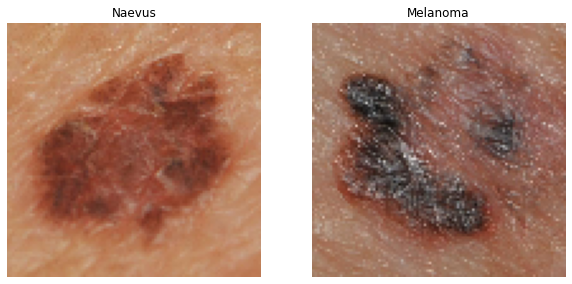

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Naevus")
plt.axis(False)
plt.imshow(n_dataset[21])

plt.subplot(1,2,2)
plt.title("Melanoma")
plt.axis(False)
plt.imshow(m_dataset[21])

In [ ]:
size_train_for_class=int(np.min([len(n_dataset),len(m_dataset)])*0.85)
size_train_for_class

59

#Estructuración de los datos para trabajar

In [ ]:
val_n_x=[]
val_n_y=[]
train_n_x=[]
train_n_y=[]
#naveus
for i in range(len(n_dataset)):
  if i<size_train_for_class:
    train_n_x.append(n_dataset[i])
    train_n_y.append(0) #naveus target 0
  else:
    val_n_x.append(n_dataset[i])
    val_n_y.append(0) #naveus target 0

train_n_x=np.array(train_n_x)
val_n_x=np.array(val_n_x)
train_n_y=np.array(train_n_y)
val_n_y=np.array(val_n_y)


val_m_x=[]
val_m_y=[]
train_m_x=[]
train_m_y=[]

#melanoma
for i in range(len(m_dataset)):
  if i<size_train_for_class:
    train_m_x.append(m_dataset[i])
    train_m_y.append(1) #melanoma target 1
  else:
    val_m_x.append(m_dataset[i])
    val_m_y.append(1) #melanoma target 1

train_m_x=np.array(train_m_x)
val_m_x=np.array(val_m_x)
train_m_y=np.array(train_m_y)
val_m_y=np.array(val_m_y)



In [ ]:
val_x = np.concatenate((val_n_x,val_m_x), axis=0)
val_y = np.concatenate((val_n_y,val_m_y), axis=0)

In [ ]:
train_x = np.concatenate((train_n_x,train_m_x), axis=0)
train_y = np.concatenate((train_n_y,train_m_y), axis=0)

#Data augmentation Train Set

In [ ]:
images_increased = 40
train_datagen = ImageDataGenerator(
    rotation_range=120,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'

)


In [ ]:
train_n_x_da=[]
train_n_y=[]
for x in train_n_x:
  x=np.expand_dims(x,axis=0)
  t=1
  for output_batch in train_datagen.flow(x,batch_size=1):
    a = keras.preprocessing.image.image.img_to_array(output_batch[0])
    image = output_batch[0,:,:]
    t+=1
    train_n_x_da.append(image)
    train_n_y.append(0) #naveus target 0

    if t>images_increased:
      break
    
train_m_x_da=[]
train_m_y=[]
for x in train_m_x:
  x=np.expand_dims(x,axis=0)
  t=1
  for output_batch in train_datagen.flow(x,batch_size=1):
    a = keras.preprocessing.image.image.img_to_array(output_batch[0])
    image = output_batch[0,:,:]
    t+=1
    train_m_x_da.append(image)
    train_m_y.append(1) #melanoma target 1

    if t>images_increased:
      break



In [ ]:
train_m_x_da=np.array(train_m_x_da)
train_m_x_da.shape

(2360, 100, 100, 3)

In [ ]:
train_x = np.concatenate((train_n_x_da,train_m_x_da), axis=0)
train_y = np.concatenate((train_n_y,train_m_y), axis=0)

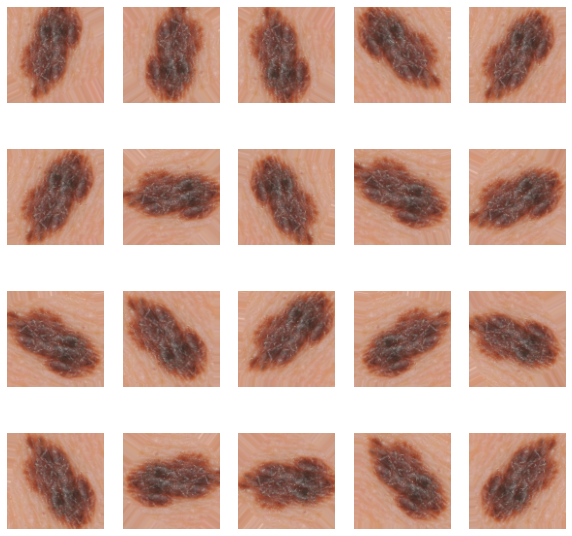

In [ ]:
#Mostrar resultados del data augmentation
n_show=20
plt.figure(figsize=(10,10),)
for i in range(1,n_show+1):
  plt.subplot(4,5,i)
  plt.imshow(train_x[i+1800])
  plt.axis(False)
  
#plt.title("Naevus")

#plt.subplot(1,4,2)
#plt.title("Melanoma")
#plt.imshow(m_dataset[2])
#plt.subplot(1,4,3)
#plt.title("Melanoma")
#plt.imshow(m_dataset[3])
#plt.subplot(1,4,4)
#plt.title("Melanoma")
#plt.imshow(m_dataset[4])

#Data augmentation de Val set

In [ ]:
val_n_x_da=[]
val_n_y=[]
for x in val_n_x:
  x=np.expand_dims(x,axis=0)
  t=1
  for output_batch in train_datagen.flow(x,batch_size=1):
    a = keras.preprocessing.image.image.img_to_array(output_batch[0])
    image = output_batch[0,:,:]
    t+=1
    val_n_x_da.append(image)
    val_n_y.append(0) #naveus target 0

    if t>images_increased:
      break
    
val_m_x_da=[]
val_m_y=[]
for x in val_m_x:
  x=np.expand_dims(x,axis=0)
  t=1
  for output_batch in train_datagen.flow(x,batch_size=1):
    a = keras.preprocessing.image.image.img_to_array(output_batch[0])
    image = output_batch[0,:,:]
    t+=1
    val_m_x_da.append(image)
    val_m_y.append(1) #melanoma target 1

    if t>images_increased:
      break

In [ ]:
val_x = np.concatenate((val_n_x_da,val_m_x_da), axis=0)
val_y = np.concatenate((val_n_y,val_m_y), axis=0)

#Stop early

In [ ]:
from tensorflow.keras import layers
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=15)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.0001,
    patience=3,
    verbose=0,
    mode="auto",
    min_delta=0.00001,
    cooldown=0,
    min_lr=0.0001
   
)

#Class Tunner

In [ ]:
class CVTuner(kt.engine.tuner.Tuner):

  def run_trial(self, trial, x, y, *args, **kwargs):
    a__ = int(train_x.shape[0])
    b__ = int(int(train_x.shape[0])/2)
    c__ = int(int(train_x.shape[0])/4)
    val_accuracy = []
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values=[a__,b__,c__])
    kwargs['epochs'] = trial.hyperparameters.Choice('epochs',values=[100])

    model = self.hypermodel.build(trial.hyperparameters)

    model.fit(x, y,validation_split=0.1,callbacks=[stop_early], shuffle= True)

    val_accuracy.append(f1_score(val_y.astype(np.int64),np.around(model.predict(val_x)), average='micro'))

    self.oracle.update_trial(trial.trial_id, {'val_accuracy': np.mean(val_accuracy)})
    self.save_model(trial.trial_id, model)
    

#Función para plotear entrenamientos

In [ ]:
#Función para plotear el entreamiento de los modelos.
def train_results(histories):
  colors=["red","blue"]
  fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = ((18, 8)),)
 
  ax = axs[0]
  ax.set_title('Loss')
  ax.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  train_loss, val_loss = histories.history['loss'], histories.history['val_loss']
  ax.plot(train_loss, label = 'Train loss ', color = colors[0], linestyle = '-', alpha = 0.5)
  ax.plot(val_loss, label = 'Val loss', color = colors[1],linestyle=":")
  ax.set_xlabel('Epochs', fontsize = 13)
  ax.legend()

  ax = axs[1]
  ax.set_title('Accuracy')
  ax.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  train_accuracy, val_accuracy = histories.history['accuracy'], histories.history['val_accuracy']
  ax.plot(train_accuracy, label = 'Train accuracy', color = colors[0], linestyle = '-', alpha = 0.5)
  ax.plot(val_accuracy, label = 'Val accuracy', color = colors[1],linestyle=":")
  ax.set_xlabel('Epochs', fontsize = 13)
  ax.legend()

  plt.show()

#Librerías Secundarias 

In [ ]:
import numpy as np
import random
from osgeo import gdal_array
from sklearn.feature_extraction import image
import itertools, random
import matplotlib.pyplot as plt
from osgeo import gdal_array
from sklearn.feature_extraction import image
from sklearn.model_selection import KFold
import itertools, random
from sklearn.model_selection import train_test_split
import kerastuner as kt
import sklearn
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
import seaborn as sns
import statistics

physical_devices = tf.config.experimental.list_physical_devices('GPU')


#MLP

In [ ]:
#Se define hipermodelo
def model_builder_3(hp):
  model = keras.Sequential()
  #Input
  model.add(keras.layers.Flatten())

  #Hiperparámetros
  hp_neuronas_1 = hp.Choice('Neuronas_1', values = [85,75,80])
  hp_Dropout = hp.Choice('DO', values = [0.35,0.45,0.25])

  #Capas Densas
  model.add(keras.layers.Dense(hp_neuronas_1, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.1), activation='relu'))
  model.add(keras.layers.Dropout(hp_Dropout))
  model.add(keras.layers.Dense(hp_neuronas_1, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.1), activation='relu'))
  model.add(keras.layers.Dropout(hp_Dropout))
  model.add(keras.layers.Dense(hp_neuronas_1, activation='relu'))
  model.add(keras.layers.Dropout(hp_Dropout))


  #Output Layer
  model.add(keras.layers.Dense(1,activation='sigmoid'))

  #Otros Hyperparámetros 
  hp_learning_rate = hp.Choice('learning_rate', values=[1.5e-3, 1e-3, 1.2e-3])
  hp_optimizer = hp.Choice('optimizer', values=[1,0])


  if hp_optimizer == 1:
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
  else:
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])    

  return model 

In [ ]:
#Se corre class Tuner con estas características dado el modelo
tuner = CVTuner(
  hypermodel=model_builder_3,
  oracle=kt.oracles.BayesianOptimization(
    objective='val_accuracy',
    beta = 8,
    max_trials=15),
    project_name='Machine_Learninining__________________')


tuner.search(train_x,train_y,callbacks=[stop_early])

Trial 15 Complete [00h 00m 02s]
val_accuracy: 0.7966346153846153

Best val_accuracy So Far: 0.8278846153846153
Total elapsed time: 00h 00m 36s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#Hiperparámetros seleccionados
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('Dropout: ',best_hps.get('DO')," Learning rate: ",best_hps.get('learning_rate')," Optimizer: ",best_hps.get('optimizer'),'Batch size:',best_hps.get('batch_size'), 'Neuronas_1:',best_hps.get('Neuronas_1'))


Dropout:  0.25  Learning rate:  0.0015  Optimizer:  0 Batch size: 4720 Neuronas_1: 80


In [ ]:
#Entrenamiento del modelo seleccionado
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_x, train_y, epochs=100, validation_split=0.1,callbacks=[stop_early], shuffle=True)
f1_train = f1_score(train_y.astype(np.int64),np.around(model.predict(train_x)), average='micro')
f1_val = f1_score(val_y.astype(np.int64),np.around(model.predict(val_x)), average='micro')
print("f1 train: ",f1_train)
print("f1 val: ",f1_val)

Epoch 1/100
133/133 [==============================] - 1s 6ms/step - loss: 40.3402 - accuracy: 0.5734 - val_loss: 38.7056 - val_accuracy: 0.1229
Epoch 2/100
133/133 [==============================] - 1s 5ms/step - loss: 36.8261 - accuracy: 0.6217 - val_loss: 35.3931 - val_accuracy: 0.2564
Epoch 3/100
133/133 [==============================] - 1s 5ms/step - loss: 33.5897 - accuracy: 0.6563 - val_loss: 32.3716 - val_accuracy: 0.2479
Epoch 4/100
133/133 [==============================] - 1s 5ms/step - loss: 30.6125 - accuracy: 0.6622 - val_loss: 29.4009 - val_accuracy: 0.3390
Epoch 5/100
133/133 [==============================] - 1s 5ms/step - loss: 27.8731 - accuracy: 0.6806 - val_loss: 26.7635 - val_accuracy: 0.3390
Epoch 6/100
133/133 [==============================] - 1s 5ms/step - loss: 25.3468 - accuracy: 0.6944 - val_loss: 24.2028 - val_accuracy: 0.5678
Epoch 7/100
133/133 [==============================] - 1s 5ms/step - loss: 23.0287 - accuracy: 0.7029 - val_loss: 22.0022 - val_ac

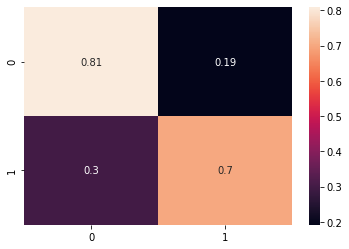

In [ ]:
#Mostrar predicciones
conf_mat = confusion_matrix(val_y.astype(np.int64), np.around(model.predict(val_x)),normalize="true")
sns.heatmap(conf_mat / np.sum(conf_mat, axis=1), annot=True)
plt.show()

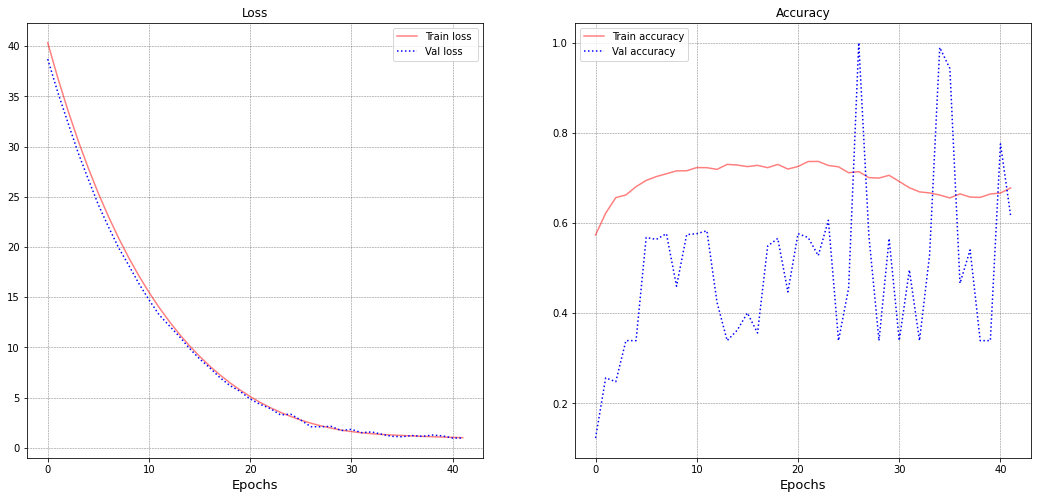

In [ ]:
#Mostrar el entrenamiento
train_results(history)

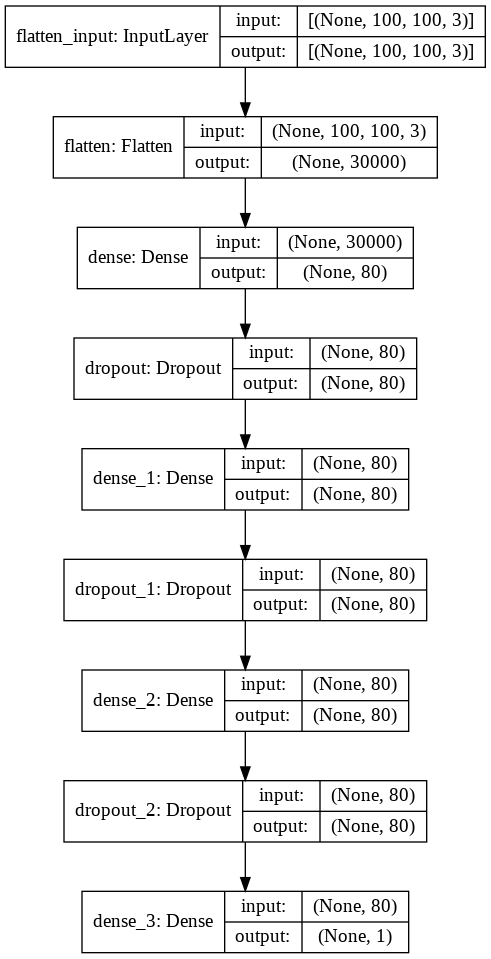

In [ ]:
#Mostrar el modelo MLP
keras.utils.plot_model(model, '/content/drive/MyDrive/ProyectoML/figs/LRtf.png', show_shapes=True)

#CNN1


In [ ]:
#Se define el hipermodelo
def model_builder(hp):
  
  #Hyperparámetros
  hp_learning_rate = hp.Choice('learning_rate', values=[1.5e-4, 1.5e-3, 1e-3,1e-4])
  hp_optimizer = hp.Choice('optimizer', values=[1,0])
  hp_K_S = hp.Choice('Kernel_size',values=[2,3])
  hp_M_P = hp.Choice('MP', values = [2,3])

  model = Sequential()
  #Input
  model.add(keras.layers.InputLayer(input_shape=(100, 100, 3)))
  #Capas convolucionales
  model.add(keras.layers.Conv2D(32*2, (hp_K_S, hp_K_S), activation='relu'))
  model.add(keras.layers.MaxPooling2D((hp_M_P, hp_M_P)))
  model.add(keras.layers.Conv2D(64*2, (hp_K_S, hp_K_S), activation='relu'))
  model.add(keras.layers.MaxPooling2D((hp_M_P, hp_M_P)))
  model.add(keras.layers.Conv2D(128*2, (hp_K_S, hp_K_S), activation='relu', padding='same'))
  model.add(keras.layers.MaxPooling2D((hp_M_P, hp_M_P)))
  model.add(keras.layers.Conv2D(256*2, (hp_K_S, hp_K_S), activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(1024*2, (hp_K_S, hp_K_S), activation='relu', padding='same'))
  model.add(keras.layers.MaxPooling2D((hp_M_P, hp_M_P)))


  #Output 
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(1,activation='sigmoid'))

  
  

  if hp_optimizer == 1:
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
  else:
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])    
                  

  return model

In [ ]:
#Se corre el Class Tuner
tuner = CVTuner(
  hypermodel=model_builder,
  oracle=kt.oracles.BayesianOptimization(
    objective='val_accuracy',
    beta = 8,
    max_trials=30),
    project_name='Mac_')


tuner.search(train_x,train_y,callbacks=[stop_early])

Trial 30 Complete [00h 00m 05s]
val_accuracy: 0.8254807692307692

Best val_accuracy So Far: 0.8451923076923077
Total elapsed time: 00h 05m 09s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#Hiperparámetros
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(" Learning rate: ",best_hps.get('learning_rate')," Optimizer: ",best_hps.get('optimizer'),'Kernel Size', best_hps.get('Kernel_size'),'Maxpooling', best_hps.get('MP'),'Batch size',best_hps.get('batch_size'))

 Learning rate:  0.0015  Optimizer:  1 Kernel Size 2 Maxpooling 3 Batch size 4720


In [ ]:
#Entrenamiento
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_x, train_y, epochs=50, validation_split=0.1,callbacks=[stop_early], shuffle=True)


f1_train = f1_score(train_y.astype(np.int64),np.around(model.predict(train_x)), average='micro')
f1_val = f1_score(val_y.astype(np.int64),np.around(model.predict(val_x)), average='micro')
print("f1 train: ",f1_train)
print("f1 val: ",f1_val)

Epoch 1/50
133/133 [==============================] - 4s 29ms/step - loss: 0.5856 - accuracy: 0.6914 - val_loss: 0.8090 - val_accuracy: 0.3390
Epoch 2/50
133/133 [==============================] - 4s 28ms/step - loss: 0.5031 - accuracy: 0.7540 - val_loss: 0.4605 - val_accuracy: 0.7712
Epoch 3/50
133/133 [==============================] - 4s 28ms/step - loss: 0.4464 - accuracy: 0.8018 - val_loss: 0.2233 - val_accuracy: 0.9915
Epoch 4/50
133/133 [==============================] - 4s 28ms/step - loss: 0.3828 - accuracy: 0.8411 - val_loss: 0.6610 - val_accuracy: 0.6907
Epoch 5/50
133/133 [==============================] - 4s 28ms/step - loss: 0.3163 - accuracy: 0.8670 - val_loss: 0.4992 - val_accuracy: 0.7627
Epoch 6/50
133/133 [==============================] - 4s 28ms/step - loss: 0.2510 - accuracy: 0.8924 - val_loss: 1.1818 - val_accuracy: 0.7013
Epoch 7/50
133/133 [==============================] - 4s 28ms/step - loss: 0.2375 - accuracy: 0.9049 - val_loss: 0.6331 - val_accuracy: 0.7521

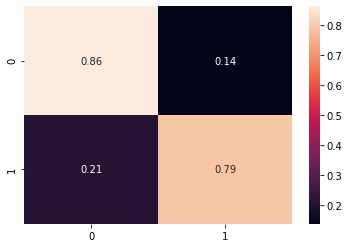

In [ ]:
#Predicciones
conf_mat = confusion_matrix(val_y.astype(np.int64), np.around(model.predict(val_x)),normalize="true")
sns.heatmap(conf_mat / np.sum(conf_mat, axis=1), annot=True)
plt.show()

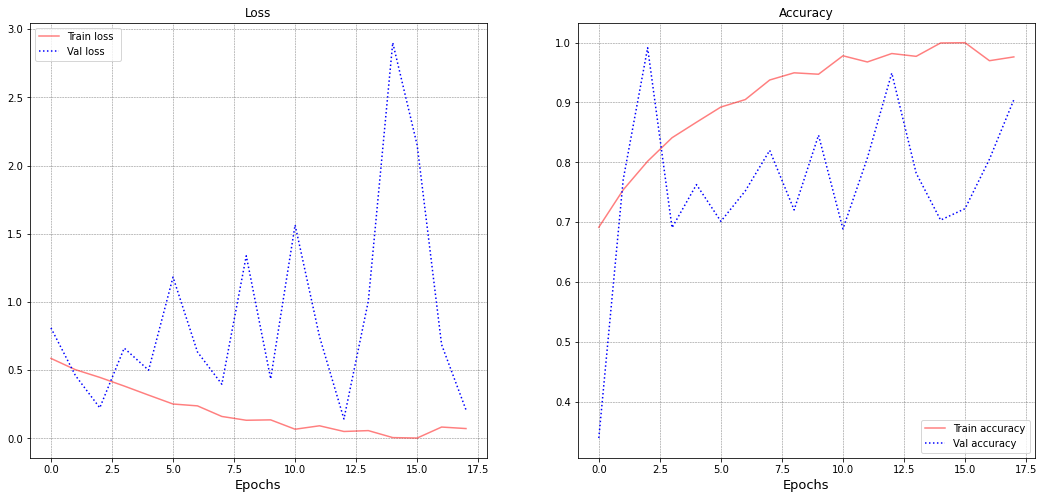

In [ ]:
#Se muestra el entrenamiento
train_results(history)

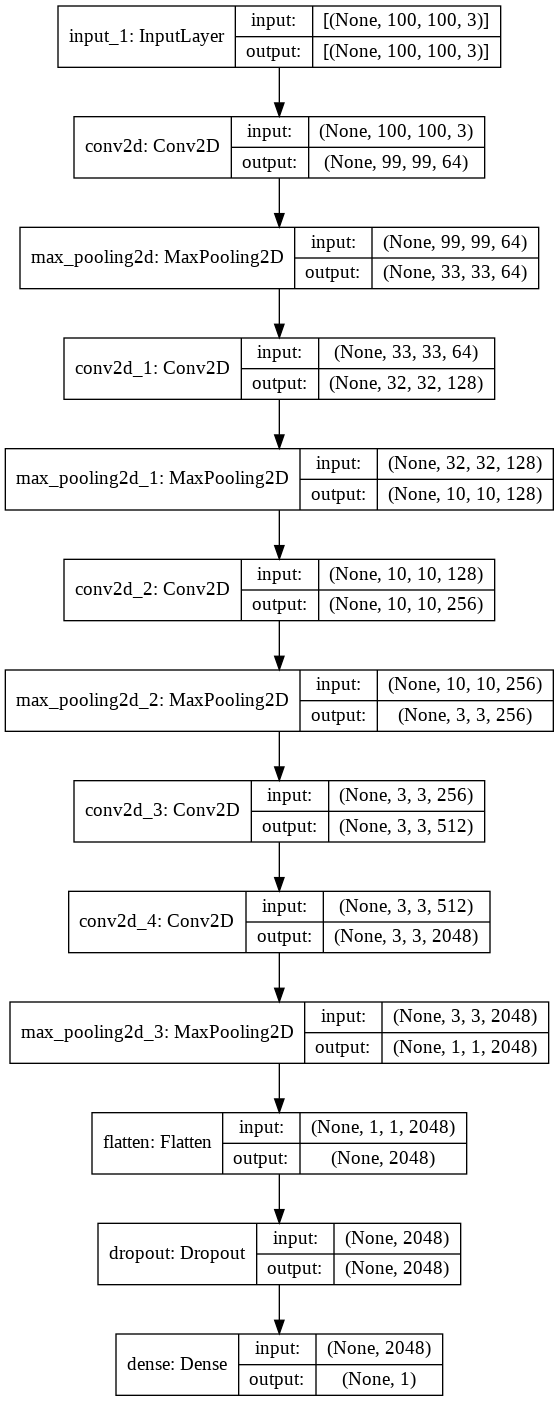

In [ ]:
#Se muestra la arquitectura del modelo
keras.utils.plot_model(model, '/content/drive/MyDrive/ProyectoML/figs/LRtf.png', show_shapes=True)

#CNN2

In [ ]:
#Se define el hipermodelo
def model_builder_2(hp):
  
  #Hyperparámetros
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-7, 1e-6, 1e-5,1e-4])
  hp_optimizer = hp.Choice('optimizer', values=[0,1])
  hp_K_S = hp.Choice('Kernel_size',values=[2,3])
  hp_M_P = hp.Choice('MP', values = [2,3])
  hp_CD = hp.Choice('CD', values = [1,2,3])
  hp_L1 = hp.Choice('L1', values = [0.0001, 0.001, 0.01] )
  hp_L2 = hp.Choice('L2', values = [0.0001, 0.001, 0.01] )
  hp_Dropout = hp.Choice('DO', values = [0.25 , 0.35 , 0.45])


  model = Sequential()
  #Input
  model.add(keras.layers.InputLayer(input_shape=(100, 100, 3)))

  #Capas convolucionales
  model.add(keras.layers.Conv2D(32*2, (hp_K_S, hp_K_S), activation='relu'))
  model.add(keras.layers.MaxPooling2D((hp_M_P, hp_M_P)))
  model.add(keras.layers.Conv2D(64*2, (hp_K_S, hp_K_S), activation='relu'))
  model.add(keras.layers.MaxPooling2D((hp_M_P, hp_M_P)))
  model.add(keras.layers.Conv2D(128*2, (hp_K_S, hp_K_S), activation='relu', padding='same'))
  model.add(keras.layers.MaxPooling2D((hp_M_P, hp_M_P)))
  model.add(keras.layers.Conv2D(256*2, (hp_K_S, hp_K_S), activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(1024*2, (hp_K_S, hp_K_S), activation='relu', padding='same'))



  model.add(keras.layers.Flatten())

  #Capas densas

  for i in range(hp_CD):
      model.add(keras.layers.Dense(80, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=hp_L1, l2=hp_L2), activation='relu'))
      model.add(keras.layers.Dropout(hp_Dropout))
  
  model.add(keras.layers.Dense(1,activation='sigmoid'))
  

  if hp_optimizer == 1:
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
  else:
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])    
                  

  return model

In [ ]:
#Se corre el Class Tuner
tuner = CVTuner(
  hypermodel=model_builder_2,
  oracle=kt.oracles.BayesianOptimization(
    objective='val_accuracy',
    beta = 8,
    max_trials=40),
    project_name='MACHINE_l')


tuner.search(train_x,train_y,callbacks=[stop_early])

Trial 40 Complete [00h 00m 06s]
val_accuracy: 0.8264423076923076

Best val_accuracy So Far: 0.8264423076923076
Total elapsed time: 00h 08m 54s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#Mejores hiperparámetros
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("L1: ",best_hps.get('L1')," L2: ",best_hps.get('L2'),'Dropout: ',best_hps.get('DO')," Learning rate: ",best_hps.get('learning_rate')," Optimizer: ",best_hps.get('optimizer'),'Kernel Size:', best_hps.get('Kernel_size'),'Maxpooling:', best_hps.get('MP'),'Batch size:',best_hps.get('batch_size'),'Capas densa:',best_hps.get('CD'))


L1:  0.01  L2:  0.01 Dropout:  0.25  Learning rate:  0.0001  Optimizer:  1 Kernel Size: 3 Maxpooling: 3 Batch size: 1180 Capas densa: 1


In [ ]:
#Entrenamiento del modelo
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_x, train_y, epochs=100, validation_split=0.1,callbacks=[stop_early], shuffle=True)


f1_train = f1_score(train_y.astype(np.int64),np.around(model.predict(train_x)), average='micro')
f1_val = f1_score(val_y.astype(np.int64),np.around(model.predict(val_x)), average='micro')
print("f1 train: ",f1_train)
print("f1 val: ",f1_val)

Epoch 1/100
133/133 [==============================] - 5s 32ms/step - loss: 60.9957 - accuracy: 0.6650 - val_loss: 10.7407 - val_accuracy: 0.3390
Epoch 2/100
133/133 [==============================] - 4s 31ms/step - loss: 2.1487 - accuracy: 0.7382 - val_loss: 0.7949 - val_accuracy: 0.7436
Epoch 3/100
133/133 [==============================] - 4s 31ms/step - loss: 0.7860 - accuracy: 0.7594 - val_loss: 0.9036 - val_accuracy: 0.7203
Epoch 4/100
133/133 [==============================] - 4s 31ms/step - loss: 0.7127 - accuracy: 0.7735 - val_loss: 0.8944 - val_accuracy: 0.7436
Epoch 5/100
133/133 [==============================] - 4s 32ms/step - loss: 0.6894 - accuracy: 0.7717 - val_loss: 0.5961 - val_accuracy: 0.7881
Epoch 6/100
133/133 [==============================] - 4s 31ms/step - loss: 0.6815 - accuracy: 0.7832 - val_loss: 0.8592 - val_accuracy: 0.7458
Epoch 7/100
133/133 [==============================] - 4s 31ms/step - loss: 0.6416 - accuracy: 0.7980 - val_loss: 1.1584 - val_accurac

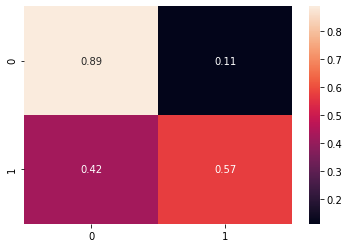

In [ ]:
#Predicciones
conf_mat = confusion_matrix(val_y.astype(np.int64), np.around(model.predict(val_x)),normalize="true")
sns.heatmap(conf_mat / np.sum(conf_mat, axis=1), annot=True)
plt.show()

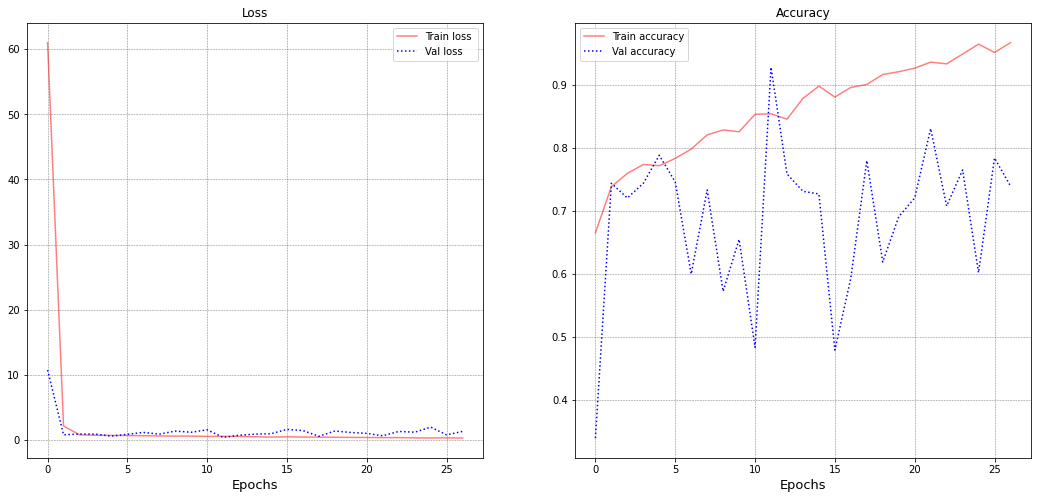

In [ ]:
#Se muestra el entrenamiento
train_results(history)

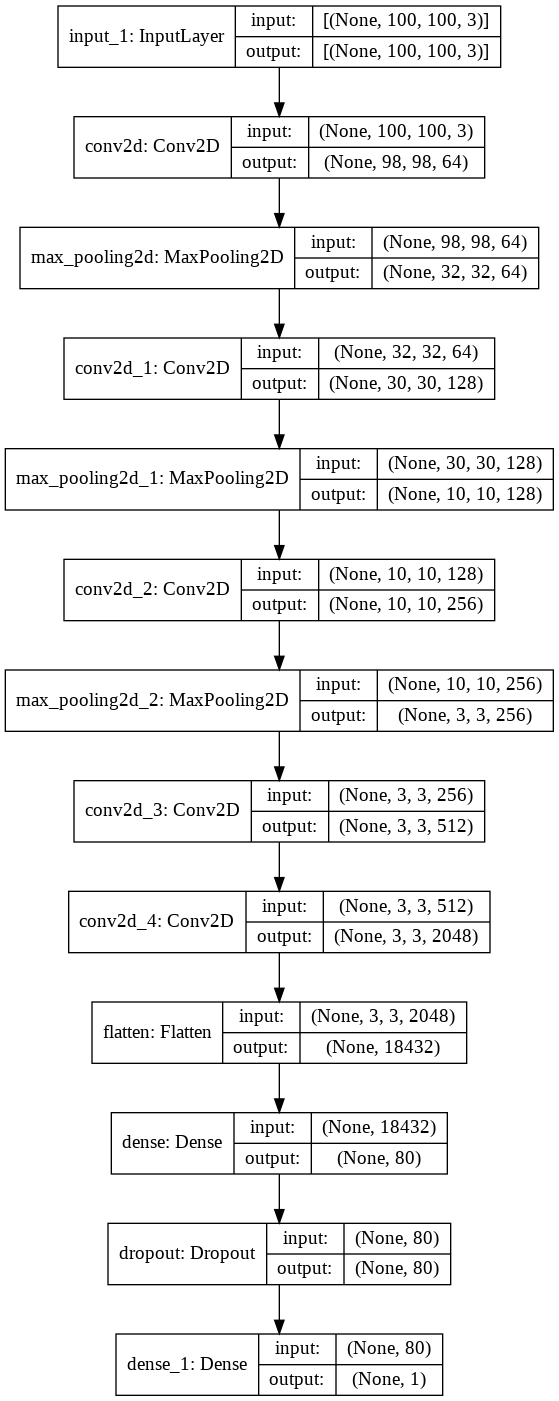

In [ ]:
#Se muestra la estructura del modelo
keras.utils.plot_model(model, '/content/drive/MyDrive/ProyectoML/figs/LRtf.png', show_shapes=True)

#CM1


In [ ]:
#Se define un nuevo stop early que se adapta al modelo
from tensorflow.keras import layers
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.0001,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.00001,
    cooldown=0,
    min_lr=0.0001
   
)

In [ ]:
#Modelo
inputs = layers.Input(shape=(100, 100, 3))
#Twin 1
conv_1_t1 = layers.Conv2D(32, (5, 5), activation='relu')(inputs) 
maxp_1_t1 = layers.MaxPooling2D((2, 2))(conv_1_t1)
conv_2_t1 = layers.Conv2D(64, (5, 5), activation='relu')(maxp_1_t1) 
maxp_2_t1 = layers.MaxPooling2D((2, 2))(conv_2_t1)
conv_3_t1 = layers.Conv2D(128, (5, 5), activation='relu')(maxp_2_t1) 
maxp_3_t1 = layers.MaxPooling2D((2, 2))(conv_3_t1) 
conv_4_t1 = layers.Conv2D(256, (5, 5), activation='relu')(maxp_3_t1)
maxp_4_t1 = layers.MaxPooling2D((2, 2))(conv_4_t1)
conv_5_t1 = layers.Conv2D(256*2, (5, 5), activation='relu',padding='same')(maxp_4_t1)
maxp_5_t1 = layers.MaxPooling2D((2, 2))(conv_5_t1)
flaten_1_t1 = layers.Flatten()(maxp_5_t1)

#Twin 2
conv_1_t2 = layers.Conv2D(32, (2, 2), activation='relu')(inputs) 
maxp_1_t2 = layers.MaxPooling2D((2, 2))(conv_1_t2)
conv_2_t2 = layers.Conv2D(64, (2, 2), activation='relu')(maxp_1_t2) 
maxp_2_t2 = layers.MaxPooling2D((2, 2))(conv_2_t2)
conv_3_t2 = layers.Conv2D(128, (2, 2), activation='relu')(maxp_2_t2) 
maxp_3_t2 = layers.MaxPooling2D((2, 2))(conv_3_t2) 
conv_4_t2 = layers.Conv2D(256, (2, 2), activation='relu')(maxp_3_t2)
maxp_4_t2 = layers.MaxPooling2D((2, 2))(conv_4_t2)
flaten_1_t2 = layers.Flatten()(maxp_4_t2)


stacked_output = layers.Concatenate()([ flaten_1_t1, flaten_1_t2]) 
dense_1 = layers.Dense(3000,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(stacked_output)
dense_3 = layers.Dense(1000,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(dense_1) 
output = layers.Dense(1,activation='sigmoid')(dense_3)
model = keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer=keras.optimizers.Adam(0.0001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 96, 96, 32)   2432        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 48, 48, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 44, 44, 64)   51264       max_pooling2d_3[0][0]            
______________________________________________________________________________________________

In [ ]:
history = model.fit(train_x,train_y, epochs=300,validation_split=0.1,shuffle=True,callbacks=[stop_early,reduce_lr]) #,callbacks=[reduce_lr]

Epoch 1/300
133/133 [==============================] - 9s 52ms/step - loss: 189.7379 - accuracy: 0.5946 - val_loss: 86.0800 - val_accuracy: 0.3136
Epoch 2/300
133/133 [==============================] - 6s 46ms/step - loss: 36.0645 - accuracy: 0.7265 - val_loss: 11.1443 - val_accuracy: 0.5106
Epoch 3/300
133/133 [==============================] - 6s 46ms/step - loss: 5.7141 - accuracy: 0.7234 - val_loss: 2.5377 - val_accuracy: 0.3581
Epoch 4/300
133/133 [==============================] - 6s 46ms/step - loss: 1.3479 - accuracy: 0.7352 - val_loss: 1.2241 - val_accuracy: 0.3581
Epoch 5/300
133/133 [==============================] - 6s 46ms/step - loss: 0.9704 - accuracy: 0.7319 - val_loss: 1.1478 - val_accuracy: 0.6504
Epoch 6/300
133/133 [==============================] - 6s 46ms/step - loss: 0.9727 - accuracy: 0.7349 - val_loss: 1.0072 - val_accuracy: 0.6610
Epoch 7/300
133/133 [==============================] - 6s 46ms/step - loss: 0.9625 - accuracy: 0.7380 - val_loss: 1.1245 - val_accu

f1 train:  0.838135593220339
f1 val:  0.8100961538461537


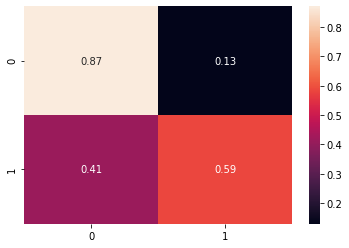

In [ ]:
#Se muestran las predicciones
f1_train = f1_score(train_y.astype(np.int64),np.around(model.predict(train_x)), average='micro')
f1_val = f1_score(val_y.astype(np.int64),np.around(model.predict(val_x)), average='micro')
print("f1 train: ",f1_train)
print("f1 val: ",f1_val)
conf_mat = confusion_matrix(val_y.astype(np.int64), np.around(model.predict(val_x)),normalize="true")
sns.heatmap(conf_mat / np.sum(conf_mat, axis=1), annot=True)
plt.show()

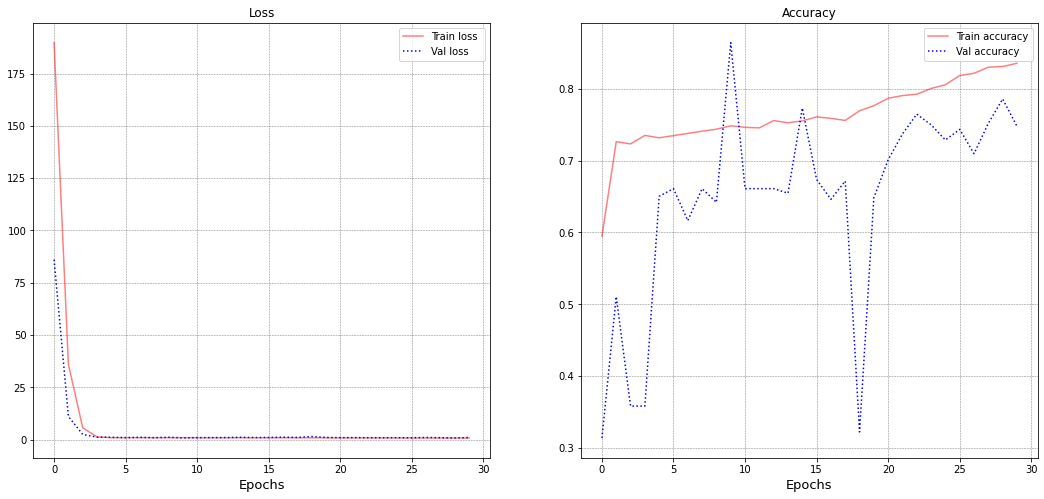

In [ ]:
#Se muestran los entrenamientos
train_results(history)

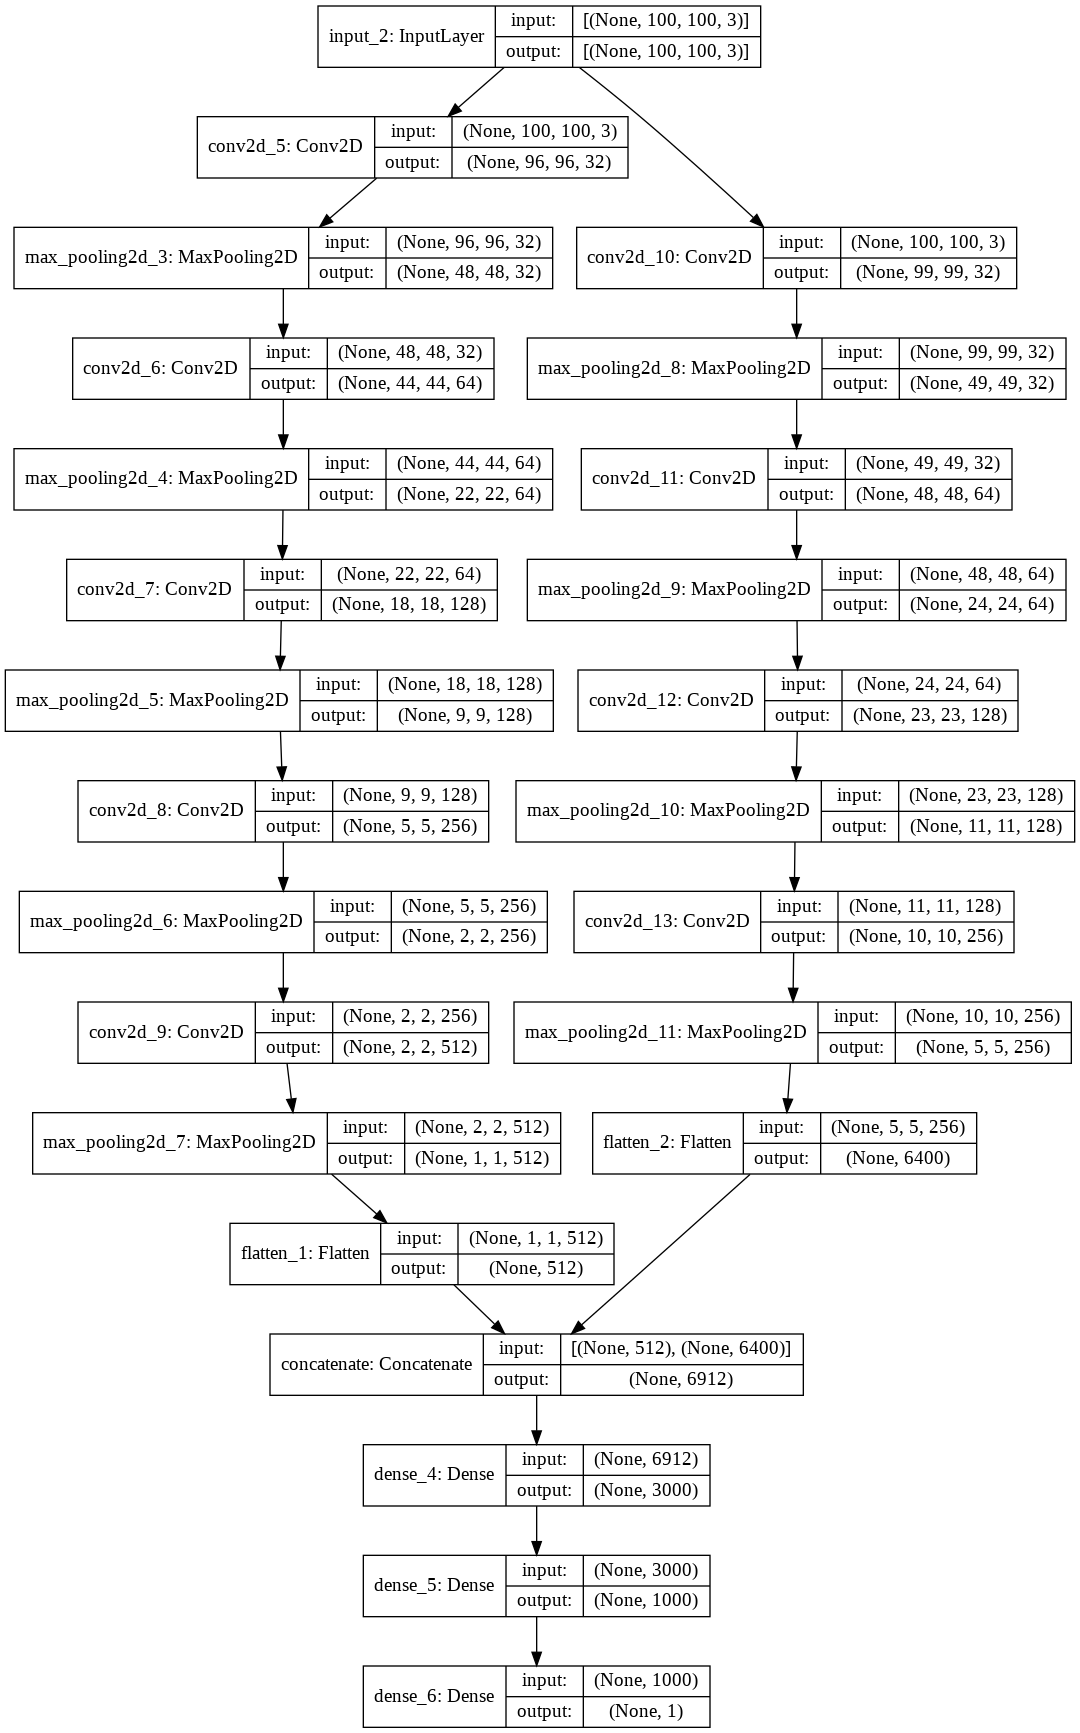

In [ ]:
#Se muestra la estructura final
keras.utils.plot_model(model, '/content/drive/MyDrive/ProyectoML/figs/LRtf.png', show_shapes=True)

#CM2


In [ ]:
#Se define stop early que se adapta al modelo
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=30)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.0001,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.00001,
    cooldown=0,
    min_lr=0.0001
   
)

In [ ]:
#Modelo
inputs = layers.Input(shape=(100, 100, 3))
rotate_1=layers.experimental.preprocessing.RandomRotation(1.0, fill_mode='nearest', interpolation='bilinear',seed=1, fill_value=0.0)(inputs)

#Twin 1
conv_1_t1 = layers.Conv2D(32, (2, 2), activation='relu')(inputs) 
maxp_1_t1 = layers.MaxPooling2D((2, 2))(conv_1_t1)
conv_2_t1 = layers.Conv2D(64, (2, 2), activation='relu')(maxp_1_t1) 
maxp_2_t1 = layers.MaxPooling2D((2, 2))(conv_2_t1)
conv_3_t1 = layers.Conv2D(128, (2, 2), activation='relu')(maxp_2_t1) 
maxp_3_t1 = layers.MaxPooling2D((2, 2))(conv_3_t1) 
conv_4_t1 = layers.Conv2D(256, (2, 2), activation='relu')(maxp_3_t1)
flaten_1_t1 = layers.Flatten()(conv_4_t1)

#Twin 2
conv_1_t2 = layers.Conv2D(32, (2, 2), activation='relu')(rotate_1) 
maxp_1_t2 = layers.MaxPooling2D((2, 2))(conv_1_t2)
conv_2_t2 = layers.Conv2D(64, (2, 2), activation='relu')(maxp_1_t2) 
maxp_2_t2 = layers.MaxPooling2D((2, 2))(conv_2_t2)
conv_3_t2 = layers.Conv2D(128, (2, 2), activation='relu')(maxp_2_t2) 
maxp_3_t2 = layers.MaxPooling2D((2, 2))(conv_3_t2) 
conv_4_t2 = layers.Conv2D(256, (2, 2), activation='relu')(maxp_3_t2)
flaten_1_t2 = layers.Flatten()(conv_4_t2)

#Concatenate
stacked_output = keras.layers.Concatenate()([flaten_1_t1, flaten_1_t2]) #

dense_1 = layers.Dense(1000,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(stacked_output)
output = layers.Dense(1,activation='sigmoid')(dense_1)
model = keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer=keras.optimizers.Adam(0.0001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
random_rotation_1 (RandomRotati (None, 100, 100, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 99, 99, 32)   416         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 99, 99, 32)   416         random_rotation_1[0][0]          
____________________________________________________________________________________________

In [ ]:
history = model.fit(train_x,train_y, epochs=300,validation_split=0.1,shuffle=True,callbacks=[stop_early,reduce_lr]) #,callbacks=[reduce_lr]

Epoch 1/300
133/133 [==============================] - 9s 58ms/step - loss: 77.9677 - accuracy: 0.5737 - val_loss: 1.6996 - val_accuracy: 0.0000e+00
Epoch 2/300
133/133 [==============================] - 8s 57ms/step - loss: 1.3649 - accuracy: 0.5789 - val_loss: 1.5008 - val_accuracy: 0.3390
Epoch 3/300
133/133 [==============================] - 8s 57ms/step - loss: 1.3454 - accuracy: 0.7057 - val_loss: 1.7621 - val_accuracy: 0.3475
Epoch 4/300
133/133 [==============================] - 8s 56ms/step - loss: 1.3002 - accuracy: 0.7467 - val_loss: 1.2634 - val_accuracy: 0.7309
Epoch 5/300
133/133 [==============================] - 7s 56ms/step - loss: 1.2319 - accuracy: 0.7597 - val_loss: 1.3042 - val_accuracy: 0.7458
Epoch 6/300
133/133 [==============================] - 7s 56ms/step - loss: 1.1827 - accuracy: 0.7707 - val_loss: 1.2693 - val_accuracy: 0.7458
Epoch 7/300
133/133 [==============================] - 7s 56ms/step - loss: 1.1883 - accuracy: 0.7738 - val_loss: 1.3991 - val_accu

f1 train:  0.8165254237288135
f1 val:  0.8081730769230769


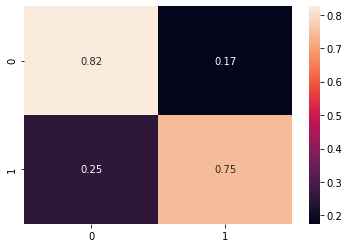

In [ ]:
#Se muestran las predicciones
f1_train = f1_score(train_y.astype(np.int64),np.around(model.predict(train_x)), average='micro')
f1_val = f1_score(val_y.astype(np.int64),np.around(model.predict(val_x)), average='micro')
print("f1 train: ",f1_train)
print("f1 val: ",f1_val)
conf_mat = confusion_matrix(val_y.astype(np.int64), np.around(model.predict(val_x)),normalize="true")
sns.heatmap(conf_mat / np.sum(conf_mat, axis=1), annot=True)
plt.show()

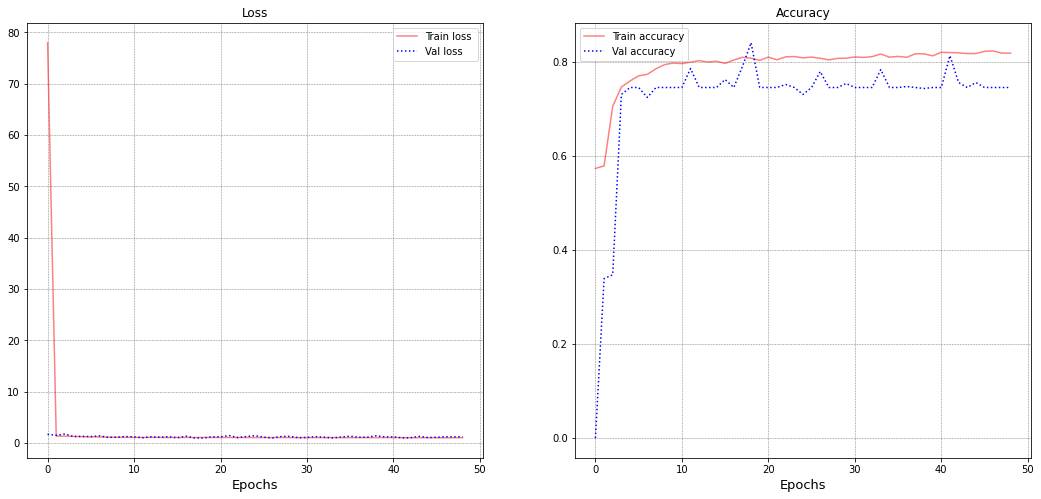

In [ ]:
#Se muestra el entrenamiento
train_results(history)

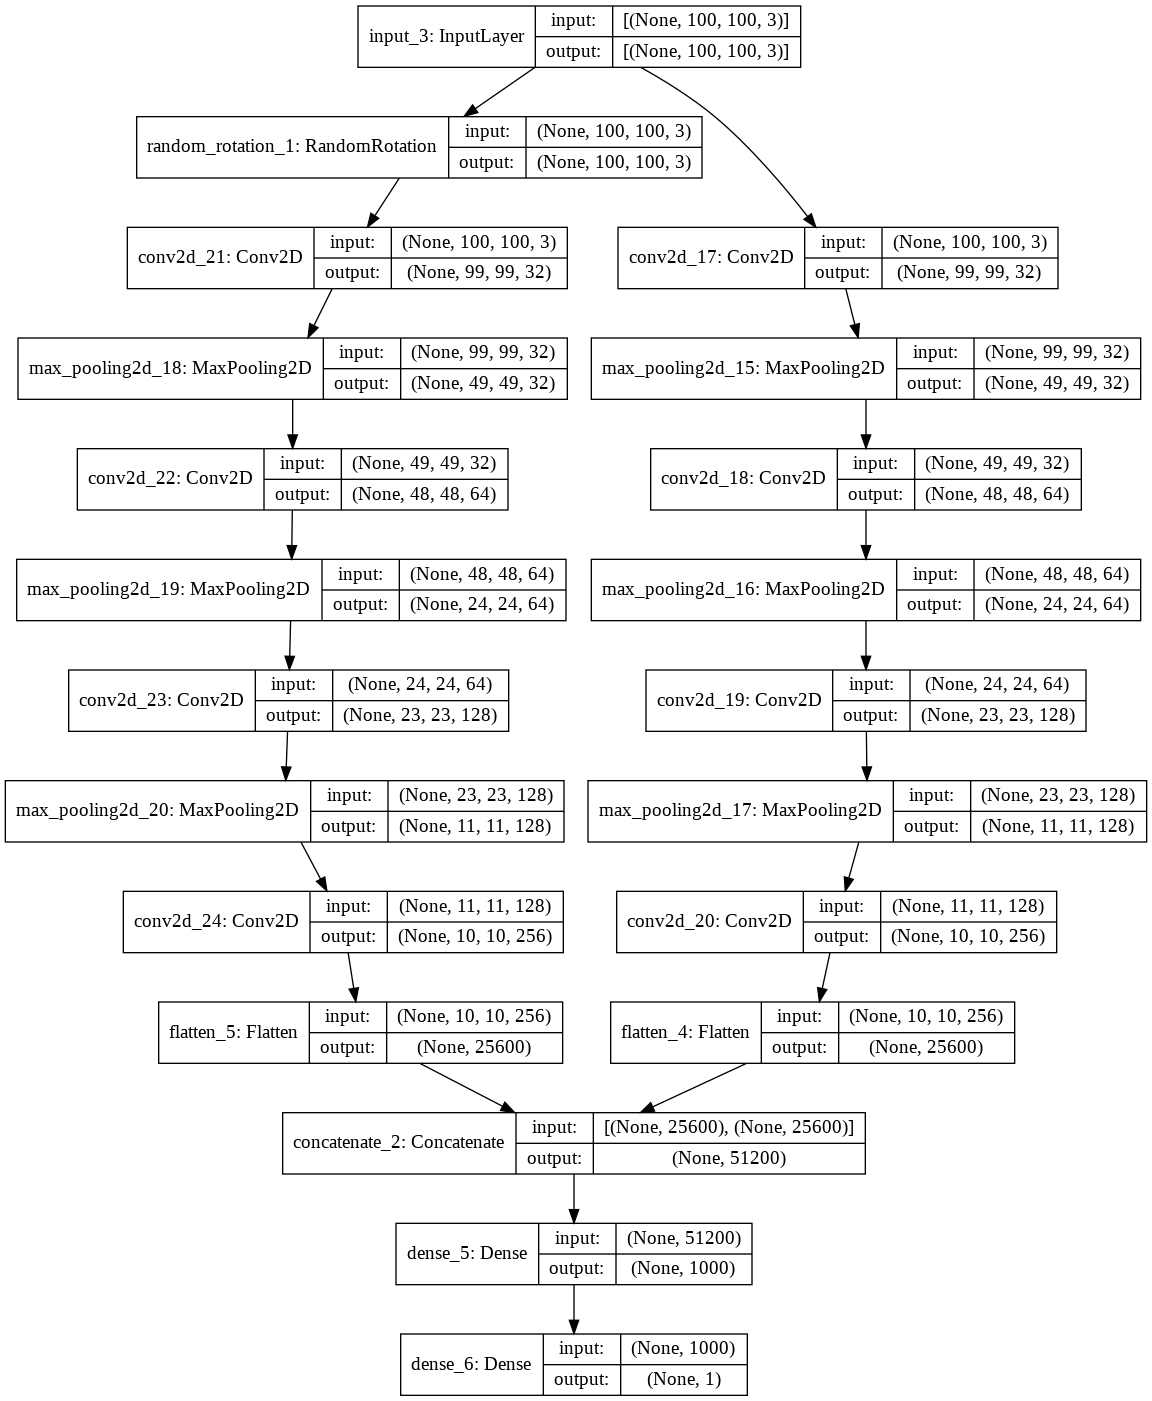

In [ ]:
#Se muestra la estructura del modelo
keras.utils.plot_model(model, '/content/drive/MyDrive/ProyectoML/figs/LRtf.png', show_shapes=True)